In [1]:
import h5py
import numpy as np
from math import log, floor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from collections import OrderedDict 
from torch.autograd import Variable

In [2]:
def extract_data(fname):
    data = {}
    with h5py.File(fname, 'r') as hf:
        values = [np.array(val) for val in hf.values()]
        data = dict(zip(hf.keys(),values))
    return data

In [3]:
ran_seq = extract_data('binary_random_20fa.hdf5')
y_human = np.ones(np.shape(ran_seq['human'])[0])
y_machine = np.zeros(np.shape(ran_seq['machine'])[0])

X = np.vstack((ran_seq['human'],ran_seq['machine']))
y = np.hstack((y_human,y_machine))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_set = TensorDataset(Tensor(X_train), Tensor(y_train))
test_set = TensorDataset(Tensor(X_val), Tensor(y_val))

batch_size = 16
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = nn.Linear(20, 20)
        self.output = nn.Linear(20, 1)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = F.sigmoid(self.output(x))
        return x

In [5]:
def train(model, epochs, device, optimizer, train_loader, test_loader):

    loss_func = nn.BCELoss();

    train_loss_list, test_loss_list, train_acc_list, test_acc_list = [] , [], [], []

    for epoch in range(epochs):

        train_loss, train_correct, test_loss, correct  = 0, 0, 0, 0
    
        for data in train_loader:

            model.train()
            
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            
            pred = torch.tensor([1 if x > 0.5 else 0 for x in outputs ])    # Binarize the values
            train_correct += pred.eq(labels.view_as(pred)).sum().item()
            
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() 

        train_acc = 100. * train_correct / (len(train_loader) * train_loader.batch_size)
        train_acc_list.append(train_acc)

        train_loss /= len(train_loader)
        train_loss_list.append(train_loss)

        model.eval()
        test_loss, correct = 0, 0

        with torch.no_grad():
            
            for data in test_loader:
                
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
            
                outputs = model(inputs).cpu()
                test_loss += loss_func(outputs, labels)
                pred = outputs.apply_(lambda x: 0.0 if x < 0.5 else 1.0)   # Binarize the values
                correct += pred.eq(labels.view_as(pred)).sum().item()
                    
        test_loss /= len(test_loader)
        test_loss_list.append(test_loss)

        test_acc = 100. * correct / (len(test_loader) * test_loader.batch_size)
        test_acc_list.append(test_acc)

        print("Epoch {} : train_loss: {:.4f}; train_acc: {:.4f}; val_loss: {:.4f}; val_acc: {:.4f}"\
            .format(epoch, train_loss, train_acc, test_loss, test_acc))

    plt.plot(np.arange(epochs), train_loss_list, label='Training loss')
    plt.plot(np.arange(epochs), test_loss_list, label='Validation loss')
    plt.xlabel('epochs')
    plt.ylabel('Binary Cross Entropy Loss')
    plt.legend()
    plt.show    
    plt.figure()
    plt.plot(np.arange(epochs), train_acc_list, label='Training Accuracy')
    plt.plot(np.arange(epochs), test_acc_list, label='Validation Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy Curves')
    plt.legend()
    plt.show()

    print('\nFinished Training and Validating ...')

Epoch 0 : train_loss: 0.6978; train_acc: 49.6324; val_loss: 0.6931; val_acc: 52.6855
Epoch 1 : train_loss: 0.6948; train_acc: 50.8333; val_loss: 0.6920; val_acc: 52.7344
Epoch 2 : train_loss: 0.6934; train_acc: 51.6422; val_loss: 0.6911; val_acc: 52.5391
Epoch 3 : train_loss: 0.6918; train_acc: 52.3162; val_loss: 0.6902; val_acc: 52.0508
Epoch 4 : train_loss: 0.6916; train_acc: 52.3407; val_loss: 0.6894; val_acc: 52.0020
Epoch 5 : train_loss: 0.6906; train_acc: 52.6103; val_loss: 0.6887; val_acc: 52.4902
Epoch 6 : train_loss: 0.6895; train_acc: 52.5245; val_loss: 0.6880; val_acc: 52.6367
Epoch 7 : train_loss: 0.6887; train_acc: 53.7990; val_loss: 0.6874; val_acc: 53.0273
Epoch 8 : train_loss: 0.6879; train_acc: 53.2721; val_loss: 0.6868; val_acc: 52.8320
Epoch 9 : train_loss: 0.6870; train_acc: 54.4240; val_loss: 0.6862; val_acc: 53.4180
Epoch 10 : train_loss: 0.6857; train_acc: 53.7990; val_loss: 0.6856; val_acc: 53.8086
Epoch 11 : train_loss: 0.6843; train_acc: 54.9142; val_loss: 0.6

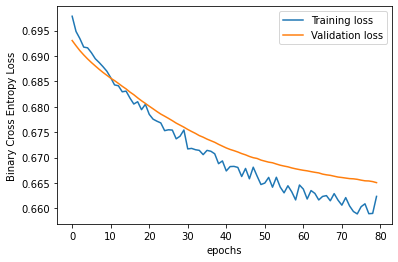

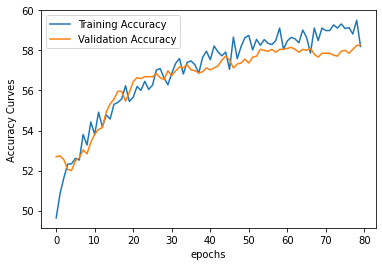


Finished Training and Validating ...


In [28]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.hidden = nn.Linear(20, 20)
        self.dropout = nn.Dropout(p = 0.25)
        self.output = nn.Linear(20, 1)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.dropout(x)
        x = F.sigmoid(self.output(x))
        return x

model1 = Net1()
model1.to(device)

num_epochs = 80
learning_rate = 1e-4
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)

train(model1, num_epochs, device, optimizer, train_loader, test_loader)

Epoch 0 : train_loss: 0.7011; train_acc: 50.7598; val_loss: 0.6938; val_acc: 53.1250
Epoch 1 : train_loss: 0.6977; train_acc: 51.0294; val_loss: 0.6918; val_acc: 52.7832
Epoch 2 : train_loss: 0.6947; train_acc: 51.3725; val_loss: 0.6904; val_acc: 53.0762
Epoch 3 : train_loss: 0.6929; train_acc: 51.8382; val_loss: 0.6895; val_acc: 53.7109
Epoch 4 : train_loss: 0.6921; train_acc: 52.3162; val_loss: 0.6887; val_acc: 53.6621
Epoch 5 : train_loss: 0.6904; train_acc: 52.2794; val_loss: 0.6879; val_acc: 54.3457
Epoch 6 : train_loss: 0.6885; train_acc: 53.1005; val_loss: 0.6872; val_acc: 54.5898
Epoch 7 : train_loss: 0.6892; train_acc: 53.4559; val_loss: 0.6866; val_acc: 55.5176
Epoch 8 : train_loss: 0.6884; train_acc: 52.9412; val_loss: 0.6860; val_acc: 55.6641
Epoch 9 : train_loss: 0.6858; train_acc: 54.3750; val_loss: 0.6854; val_acc: 55.4688
Epoch 10 : train_loss: 0.6862; train_acc: 53.8358; val_loss: 0.6848; val_acc: 55.3223
Epoch 11 : train_loss: 0.6860; train_acc: 54.0931; val_loss: 0.6

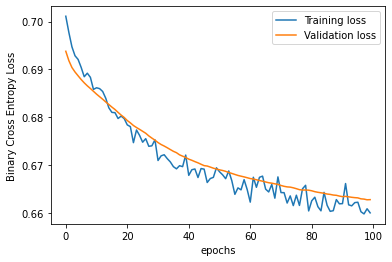

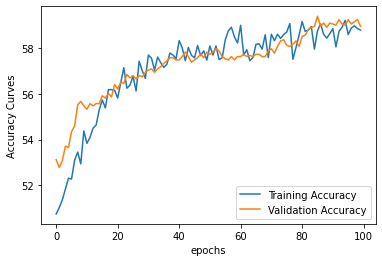


Finished Training and Validating ...


In [27]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.hidden = nn.Linear(20, 20)
        self.dropout = nn.Dropout(p = 0.3)
        self.output = nn.Linear(20, 1)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.dropout(x)
        x = F.sigmoid(self.output(x))
        return x

model2 = Net2()
model2.to(device)

num_epochs = 100
learning_rate = 1e-4
optimizer = optim.AdamW(model2.parameters(),lr=learning_rate, betas=(0.5, 0.5), amsgrad=False)

train(model2, num_epochs, device, optimizer, train_loader, test_loader)

## Model (as per question)
- The below model has the architecture as asked the question

Epoch 0 : train_loss: 0.7143; train_acc: 49.9387; val_loss: 0.7101; val_acc: 49.1699
Epoch 1 : train_loss: 0.7071; train_acc: 49.3873; val_loss: 0.7045; val_acc: 48.4863
Epoch 2 : train_loss: 0.7029; train_acc: 49.3015; val_loss: 0.7013; val_acc: 48.3398
Epoch 3 : train_loss: 0.7003; train_acc: 49.1789; val_loss: 0.6992; val_acc: 48.0957
Epoch 4 : train_loss: 0.6987; train_acc: 49.3873; val_loss: 0.6979; val_acc: 49.1211
Epoch 5 : train_loss: 0.6977; train_acc: 49.7549; val_loss: 0.6970; val_acc: 48.8770
Epoch 6 : train_loss: 0.6969; train_acc: 49.8529; val_loss: 0.6964; val_acc: 48.8770
Epoch 7 : train_loss: 0.6963; train_acc: 49.8775; val_loss: 0.6959; val_acc: 49.0234
Epoch 8 : train_loss: 0.6958; train_acc: 50.2451; val_loss: 0.6955; val_acc: 49.7070
Epoch 9 : train_loss: 0.6954; train_acc: 50.5760; val_loss: 0.6951; val_acc: 49.5117
Epoch 10 : train_loss: 0.6951; train_acc: 50.6618; val_loss: 0.6948; val_acc: 49.9512
Epoch 11 : train_loss: 0.6948; train_acc: 50.6495; val_loss: 0.6

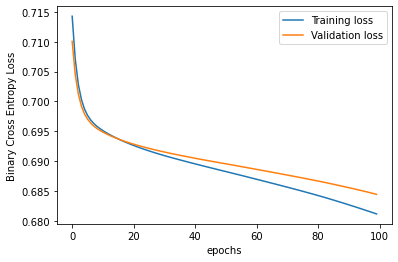

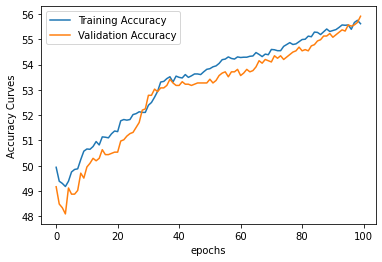


Finished Training and Validating ...


In [18]:
model3 = Net()
model3.to(device)

num_epochs = 100
learning_rate = 9e-4
optimizer = optim.ASGD(model3.parameters(),lr=learning_rate,alpha=0.5, lambd=1e-5, weight_decay=1e-4)

train(model3, num_epochs, device, optimizer, train_loader, test_loader)

In [30]:
print('\n(20 × 20) weight matrix : \n',(model2.hidden.weight))


(20 × 20) weight matrix : 
 Parameter containing:
tensor([[-0.0682, -0.0575,  0.0109, -0.1301,  0.0172, -0.0996,  0.1000, -0.2285,
         -0.1566, -0.1545,  0.0242, -0.1758,  0.1487, -0.1857,  0.1907, -0.2062,
          0.0963, -0.2620,  0.1045, -0.0737],
        [-0.0845, -0.0229,  0.2510,  0.1849, -0.3108, -0.0393,  0.0244,  0.0846,
          0.0737, -0.1958, -0.2701, -0.1385,  0.0419,  0.1474,  0.2357,  0.0631,
         -0.0474,  0.0983,  0.1407,  0.1033],
        [-0.0955, -0.0813, -0.0539,  0.0102, -0.2436,  0.0628, -0.1110,  0.1833,
         -0.0893,  0.0958, -0.2469, -0.0399, -0.3967,  0.0371, -0.2327, -0.0207,
         -0.2428,  0.0517, -0.0380,  0.1322],
        [-0.1060,  0.2627,  0.0139,  0.1958, -0.1505, -0.1705,  0.1581, -0.2936,
          0.2288,  0.1111, -0.3183,  0.0037,  0.0365,  0.1138,  0.0013, -0.0076,
         -0.0197, -0.0331,  0.0486,  0.2422],
        [ 0.1121,  0.0479,  0.0063, -0.0621, -0.0078,  0.1394,  0.1353, -0.0993,
          0.2011,  0.0884,  0.2644, 

# Analysis of the weight matrix
An inherently binary classification algorithm, it tries to find the best hyperplane in k-dimensional space that separates the 2 classes, minimizing BCE loss. The k dimensional weight vector can be used to get feature importance. Large positive values of w_j signify higher importance of the jth feature in the prediction of positive class. Large negative values signify higher importance in the prediction of negative class. This can be seen from the expression of BCE loss. SGD reduces loss by setting learning large positive weights for features more important in predicting a data point to belong to the positive class and similarly for negative class.

The model weights can be interpreted in a manner similar to that of linear regression or logistic regression. Higher the absolute value of a feature weight, more is its importance. In case two or more features have similar weights, the one whose value is more certain as indicated by its distribution, should be given higher importance, since the model is more confident about its value than it is about others.

Say suppose we take the 7th array in the weight matrix, we can see the weights alteratively switch between negative values and positive values. This can show that the prediction that it enforces on the model is almost random ie ... if it predicts human for one data point, the next data point is classified as machine. This nature of prediction with near 50% probability of prediction for each class can be seen here.